# Lab 7 - Multimodal search with CLIP

In [6]:
import requests
import zipfile
import os
import io
from PIL import Image
from IPython.display import Image as IP_Image, display
from open_clip import tokenizer, create_model_and_transforms
import torch
from sklearn.neighbors import NearestNeighbors
import numpy as np
from tqdm import tqdm

## Get the image dataset (interiors of houses)

- Source: https://www.kaggle.com/datasets/mikhailma/house-rooms-streets-image-dataset/data
- Cached: https://max.io/house_data_png.zip (resized to 256x256 and converted to PNG)
- License: CC-0 Public Domain

In [2]:
# Function to download and extract the zip file
def download_and_extract_zip(url, extract_to='.'):
    print('Downloading and extracting',url)
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_to)

# Download and extract the example images
url = "https://max.io/house_data_png.zip"
download_and_extract_zip(url)
image_dir = 'house_data_png'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
print('Extracted',len(image_paths),'images')

Extracted 5249 images


In [3]:
#Load our model.
model, transform, preprocess = create_model_and_transforms('ViT-B-32', pretrained='openai')

#Print the model architecture, note both the "visual" and "transformer" branches of the model
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  

In [7]:
#Infers images in batches.
def get_image_embeddings(image_paths, batch_size=32):
    embeddings = []

    # Process images in batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing Images"):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = [transform(Image.open(path)).unsqueeze(0) for path in batch_paths]

        # Stack and process the batch
        batch_images_tensor = torch.vstack(batch_images).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        with torch.no_grad():
            batch_embeddings = model.encode_image(batch_images_tensor)

        embeddings.append(batch_embeddings)

    # Concatenate all embeddings
    return torch.vstack(embeddings)

In [8]:
image_embeddings = get_image_embeddings(image_paths, batch_size=32)

Processing Images: 100%|██████████| 165/165 [04:12<00:00,  1.53s/it]


In [9]:
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True) #Normalization is required!

In [10]:
import pickle
with open('house_data_png.pkl', 'wb') as fd:
    pickle.dump(image_embeddings.cpu().numpy(), fd, pickle.HIGHEST_PROTOCOL)

In [11]:
print(len(image_embeddings),image_embeddings[0].shape)

5249 torch.Size([512])


In [12]:
#Encodes the text to the same vector space as the images
def embed_text(text):
    tokens = tokenizer.tokenize([text])
    with torch.no_grad():
        text_features = model.encode_text(tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True) #Normalization is required!
    return text_features

In [13]:
# Function to display images
def display_images(image_paths,distances):
    for idx,path in enumerate(image_paths):
        display(IP_Image(filename=path))
        print('👆',distances[idx])

In [14]:
# This will search and display nearest images given a text query
nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(image_embeddings.cpu().numpy())
def search(text):
    text_embedding = embed_text(text)
    distances, indices = nbrs.kneighbors(text_embedding.cpu().numpy())
    nearest_images = [image_paths[i] for i in indices[0]]
    display_images(nearest_images, distances[0])

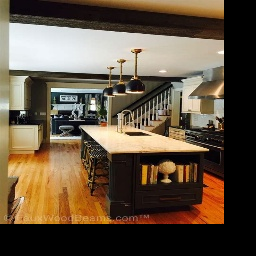

👆 0.6625057


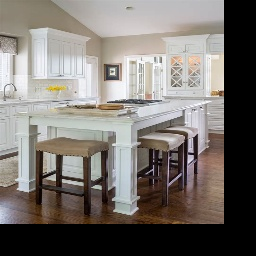

👆 0.66518945


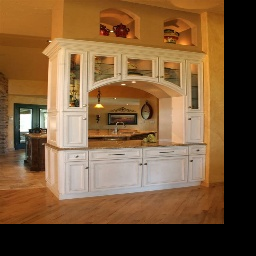

👆 0.67030954


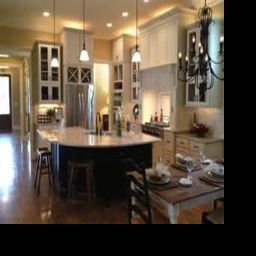

👆 0.6749306


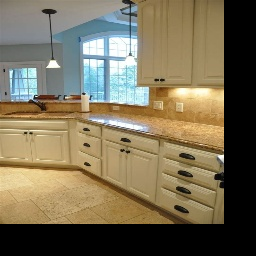

👆 0.67520225


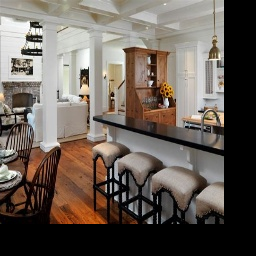

👆 0.6767603


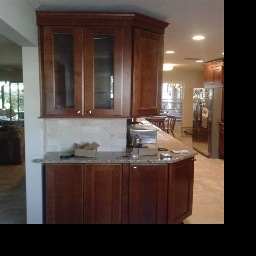

👆 0.6769491


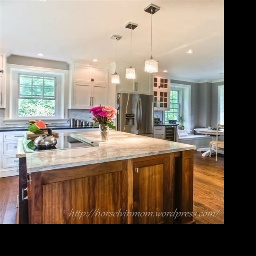

👆 0.67760766


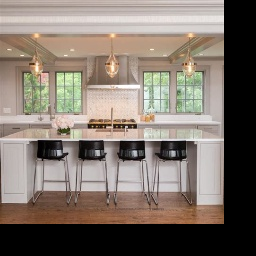

👆 0.6776702


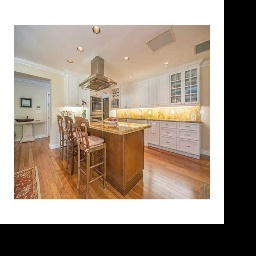

👆 0.6777445


In [15]:
search('large kitchen island colonial')

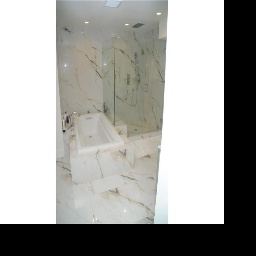

👆 0.65224624


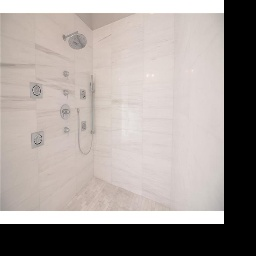

👆 0.6569178


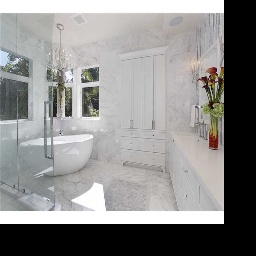

👆 0.66813314


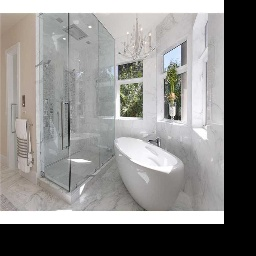

👆 0.67063814


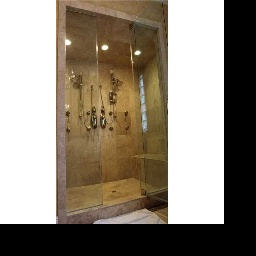

👆 0.674837


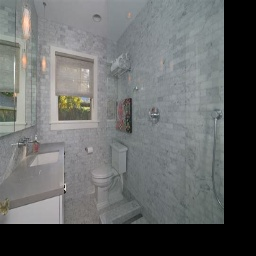

👆 0.6760773


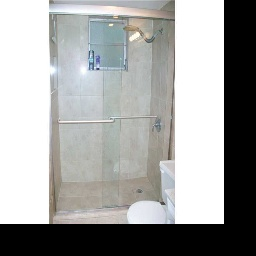

👆 0.67652416


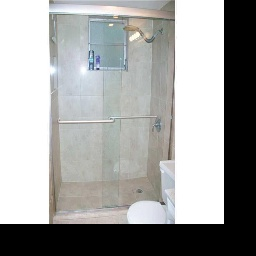

👆 0.6783269


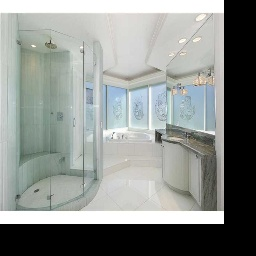

👆 0.67855316


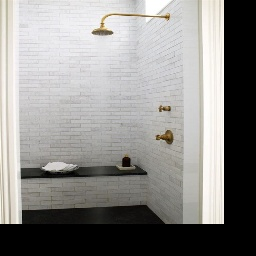

👆 0.6792083


In [16]:
search('white marble shower stall')

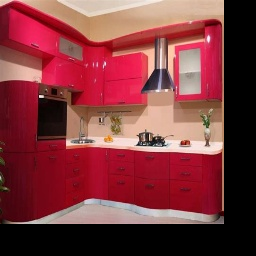

👆 0.7646489


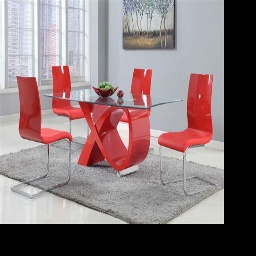

👆 0.77252793


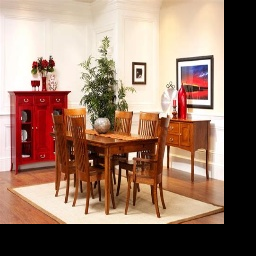

👆 0.7770121


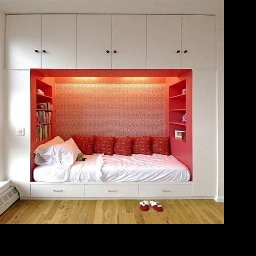

👆 0.7809282


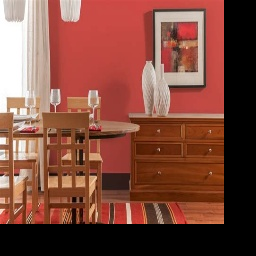

👆 0.78161615


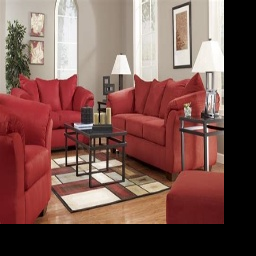

👆 0.7849709


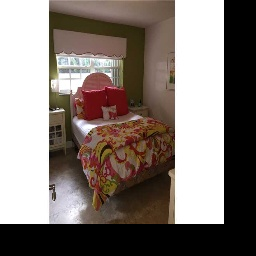

👆 0.7856353


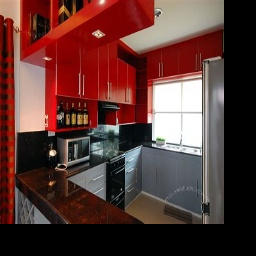

👆 0.78573585


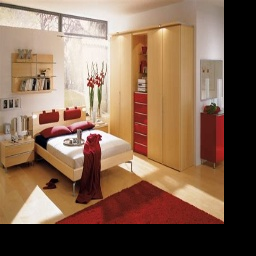

👆 0.786464


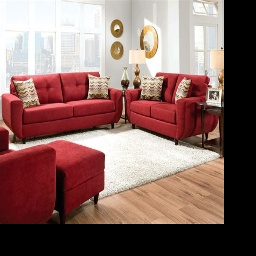

👆 0.7877757


In [17]:
search('red ferrari')

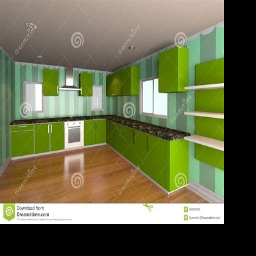

👆 0.7464835


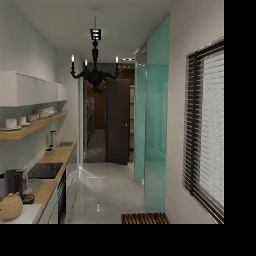

👆 0.7493081


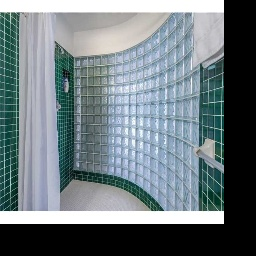

👆 0.75023127


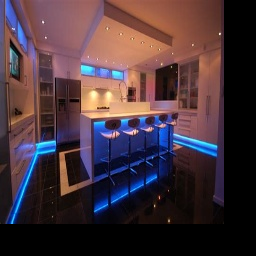

👆 0.75784945


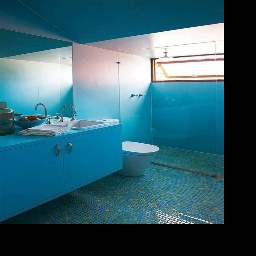

👆 0.7580104


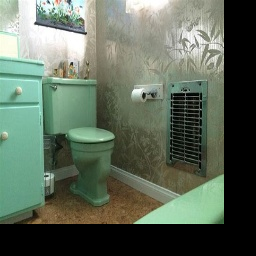

👆 0.75869215


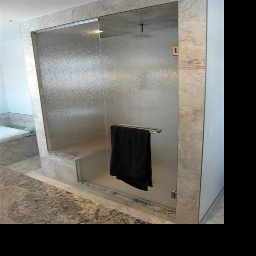

👆 0.76055837


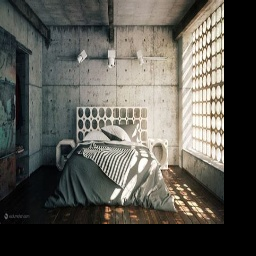

👆 0.76152027


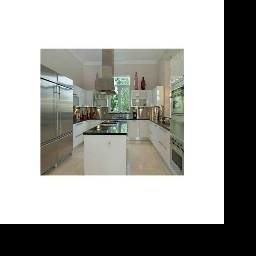

👆 0.76158917


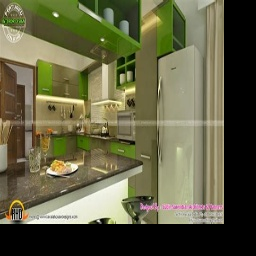

👆 0.76166165


In [18]:
search('nuclear reactor')